In [1]:
import requests
import numpy as np
from datetime import date
from pandas import DataFrame
from bs4 import BeautifulSoup
from dateutil.relativedelta import relativedelta


def todatetime(string):
    number, period, _ = string.split()
    if 'day' in period:
        delta = relativedelta(days=int(number))
    elif 'month' in period:
        delta = relativedelta(months=int(number))
    elif 'hour' in period:
        delta = relativedelta(hours=int(number))
    else:
        raise ValueError("Unexpected period {!r}".format(period))
    return date.today() - delta


def parse_name(cell):
    name = cell.text.strip().split('/')
    if len(name) != 2:
        name = cell.text.strip().split('\\')
    arch = '{}'.format(name[0].split()[1])
    name = '{}'.format(name[1].split('.tar.bz2')[0])
    return arch, name


def get_df(package):
    url = "https://binstar.org/IOOS/{}/files".format
    r  = requests.get(url(package))
    r.raise_for_status()
    soup = BeautifulSoup(r.text)
    table = soup.find("table", {"class": "table table-condensed table-striped"})

    downloads, uploaded, platforms, names = [], [], [], []
    for row in table.findAll('tr'):
        col = row.findAll('td')
        if len(col) == 7:
          downloads.append(int(col[5].text.strip()))
          uploaded.append(todatetime(col[4].text.strip()))
          platform, name = parse_name(col[3])
          platforms.append(platform)
          names.append(name)
    df = DataFrame(data=np.c_[platforms, names, uploaded, downloads],
                   columns=['platform', 'name', 'uploaded', 'downloads'])
    df.set_index('uploaded', inplace=True, drop=True)
    df['downloads'] = df['downloads'].astype(int)
    return df

In [2]:
from requests import HTTPError
from pandas import Panel, read_json

json = "https://conda.binstar.org/IOOS/linux-64/repodata.json"
df = read_json(json)

packages = sorted(set(['-'.join(pac.split('-')[:-2]) for pac in df.index]))

dfs = dict()
for pac in packages:
    try:
        dfs.update({pac: get_df(pac)})
    except HTTPError:
        continue

In [3]:
def get_plat_total(df):
    package = dict()
    for plat in ['linux-64', 'linux-32','osx-64', 'win-32', 'win-64']:
        total = df.query('platform == "{}"'.format(plat)).sum()
        package.update({plat: total['downloads']})
    return package


packages = dict()
for pac in dfs.keys():
    df = dfs[pac]
    packages.update({pac: get_plat_total(df)})

In [4]:
df = DataFrame.from_dict(packages).T
df['sum'] = df.T.sum()
df.sort('sum', ascending=False, inplace=True)
df.drop('sum', axis=1, inplace=True)

In [5]:
%matplotlib inline

import seaborn
import matplotlib.pyplot as plt

In [6]:
import matplotlib as mpl

mpl.rcParams['text.color'] = 'ivory'

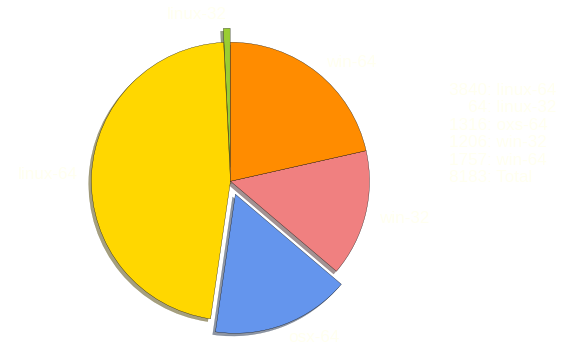

In [7]:
fig, ax = plt.subplots()

colors = ('yellowgreen', 'gold', 'cornflowerblue', 'lightcoral', 'darkorange')
kw = dict(kind='pie', fontsize=17, shadow=True, startangle=90,
          explode=(0.1, 0, 0.1, 0, 0), colors=colors)
# autopct='%1.1f%%'
ax = df.sum().plot(ax=ax, **kw)
ax.set_ylabel("")
text = "3840: linux-64\n    64: linux-32\n1316: oxs-64\n1206: win-32\n1757: win-64\n8183: Total"
ax.text(0.99, 0.5, text, fontdict=dict(fontsize=17), transform=ax.transAxes)

plt.axis('equal')

fig.savefig("total_downloads.svg", transparent=True, bbox_inches='tight')

In [8]:
mpl.rcParams['axes.labelcolor'] = 'ivory'
mpl.rcParams['xtick.color'] = 'ivory'
mpl.rcParams['ytick.color'] = 'ivory'

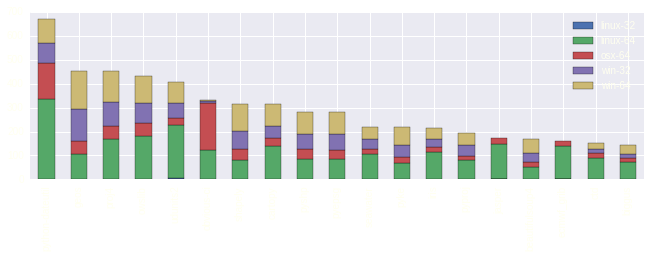

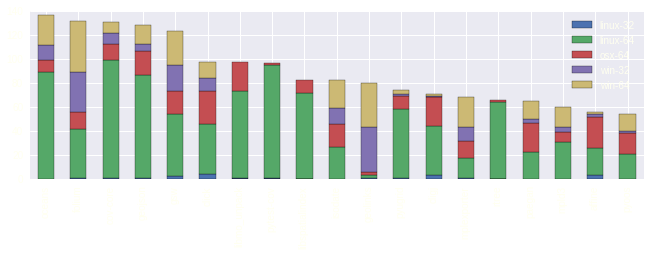

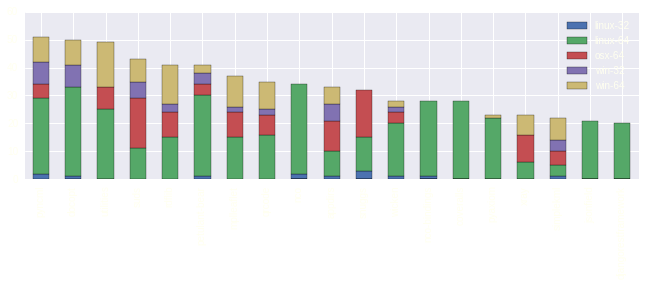

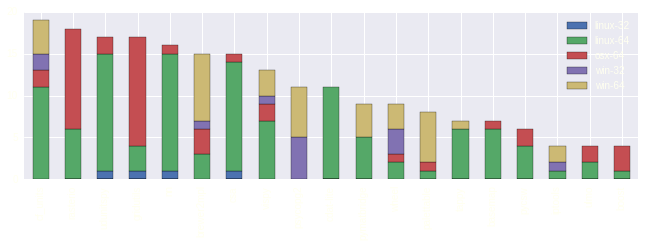

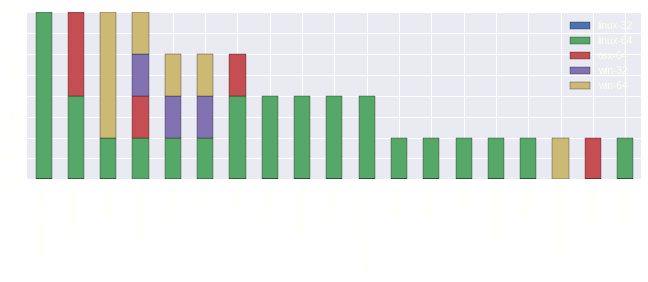

In [9]:
stride = 19 # 19 x 5 = 95
kw = dict(kind='bar', stacked=True)
figkw = dict(transparent=True, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(11, 3))
ax = df.ix[:stride].plot(ax=ax, **kw)
fig.savefig("total_downloads0.svg", **figkw)

fig, ax = plt.subplots(figsize=(11, 3))
ax = df.ix[stride:stride*2].plot(ax=ax, **kw)
fig.savefig("total_downloads1.svg", **figkw)

fig, ax = plt.subplots(figsize=(11, 3))
ax = df.ix[stride*2:stride*3].plot(ax=ax, **kw)
fig.savefig("total_downloads2.svg", **figkw)

fig, ax = plt.subplots(figsize=(11, 3))
ax = df.ix[stride*3:stride*4].plot(ax=ax, **kw)
fig.savefig("total_downloads3.svg", **figkw)

fig, ax = plt.subplots(figsize=(11, 3))
ax = df.ix[stride*4:stride*5].plot(ax=ax, **kw)
fig.savefig("total_downloads4.svg", **figkw)